In [41]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [42]:
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, homogeneity_score
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import numpy as np
import cv2
import os

In [43]:
# function to read images using cv
# resize the images to the same size of 64 x 64
# return images and corresponding labels as arrays
def readImagesAsArray(path, files, label):
    images = []
    labels = []
    for file in files:
        im = cv2.imread(os.path.join(path, file))
        im = cv2.resize(im, (64, 64))
        images.append(im)
        labels.append(label)
    return images, labels

In [44]:
# function to load dataset from file system
# will return train and test sets as np arrays
def getImageDataset(path = '/content/drive/MyDrive/CS67_Fall2022_ A1_Dataset'):
    folders = ['00001','00002','00003','00004','00005','00006','00007','00008','00009','00010']
    train_filename = 'train.txt'
    test_filename = 'test.txt'
    x_train = []
    x_test = []
    y_train = []
    y_test = []

    for i in range(1, 11):
        train_file = os.path.join(path, folders[i-1], train_filename)
        test_file = os.path.join(path, folders[i-1], test_filename)
        
        # reading text files as array of strings
        train_files_array = np.genfromtxt(train_file, dtype='str')
        test_files_array = np.genfromtxt(test_file, dtype='str')

        # getting images from the file names
        x_train_i, y_train_i = readImagesAsArray(os.path.join(path, folders[i-1]), train_files_array, i)
        x_test_i, y_test_i = readImagesAsArray(os.path.join(path, folders[i-1]), test_files_array, i)

        # appending to the train and test arrays
        x_train += x_train_i
        y_train += y_train_i
        x_test += x_test_i
        y_test += y_test_i

    # converting arrays to numpy arrays
    return x_train, y_train, x_test, y_test

In [45]:
# extract features using hog
def getFeaturesUsingHog(images):
    descriptors = []
    for im in images:
        descriptor, image = hog(im, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True)
        descriptors.append(descriptor)
    return np.array(descriptors)

In [46]:
# load datasets
x_train, y_train, x_test, y_test = getImageDataset()

# get feature descriptors for images
train_descriptors = getFeaturesUsingHog(x_train)
test_descriptors = getFeaturesUsingHog(x_test)

In [47]:
# reshape data to the 2d array as scikit models expect data in 2d format
x_train = train_descriptors.reshape((len(train_descriptors ), 512))
x_test = test_descriptors.reshape((len(test_descriptors), 512))

Supervised Learning using Random Forest Classifier

In [48]:
# we will use random forest classifier to classify images
model=RandomForestClassifier()

# training the model
model.fit(x_train, y_train)

#checking the model on test data
y_pred=model.predict(x_test)

# printing the accuracy score
accuracy_score(y_pred,y_test)

0.995

In [49]:
# Let's print the classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       0.95      1.00      0.97        19
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      0.95      0.98        21
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



Unsupervised learning using K-means Clustering

In [50]:
def getClassesArray(y_train, indexes):
  i = []
  for idx, val in enumerate(indexes):
    if val == 1:
      i.append(y_train[idx])
  return i

def get_cluster_info(cluster_labels, y_train, kmeans):
    # Initializing
    reference_labels = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(getClassesArray(y_train, index)).argmax()
        reference_labels[i] = num
    return reference_labels

In [59]:
# Initialize the K-Means model
# using 10 clusters as we have 10 classes
kmeans = KMeans(n_clusters = 10)
# Fitting the model to training set
y_kmeans = kmeans.fit_predict(x_train)

# manually getting the reference labels so we can get accuracy
reference_labels = get_cluster_info(kmeans.labels_, y_train, kmeans)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
  number_labels[i] = reference_labels[kmeans.labels_[i]]

# printing accuracy score
print(accuracy_score(number_labels,y_train))

0.8275


Let's do the same on Test data and see if we get the same accuracy.

In [55]:
kmeans = KMeans(n_clusters = 10)
# Fitting the model to test set
kmeans.fit_predict(x_test)

kmeans.labels_

# checking the accuracy on test set
reference_labels = get_cluster_info(kmeans.labels_, y_test, kmeans)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
  number_labels[i] = reference_labels[kmeans.labels_[i]]

print(accuracy_score(number_labels, y_test))

0.855


As we can see, the accuracy of both test and train data is near to each other (as the dataset is small), so we can say model is not overfitting.

Let's print the clusters and see how they are grouped.

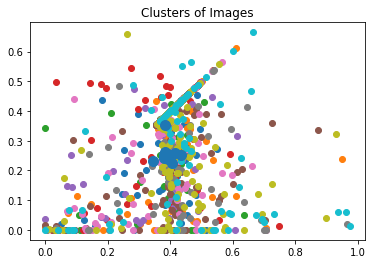

In [67]:
plt.scatter(x_train[y_kmeans==0, 0], x_train[y_kmeans==0, 1])
plt.scatter(x_train[y_kmeans==1, 0], x_train[y_kmeans==1, 1])
plt.scatter(x_train[y_kmeans==2, 0], x_train[y_kmeans==2, 1])
plt.scatter(x_train[y_kmeans==3, 0], x_train[y_kmeans==3, 1])
plt.scatter(x_train[y_kmeans==4, 0], x_train[y_kmeans==4, 1])
plt.scatter(x_train[y_kmeans==5, 0], x_train[y_kmeans==5, 1])
plt.scatter(x_train[y_kmeans==6, 0], x_train[y_kmeans==6, 1])
plt.scatter(x_train[y_kmeans==7, 0], x_train[y_kmeans==7, 1])
plt.scatter(x_train[y_kmeans==8, 0], x_train[y_kmeans==8, 1])
plt.scatter(x_train[y_kmeans==9, 0], x_train[y_kmeans==9, 1])
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, label = 'Centroids')
plt.title('Clusters of Images')
plt.show()

Links I took inspiration from while implementing this:

1. https://medium.com/@joel_34096/k-means-clustering-for-image-classification-a648f28bdc47#:~:text=Yes!,Here's%20how.&text=K%2Dmeans%20clustering%20is%20an,cluster%20with%20the%20nearest%20centroid.
2. https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/